# VAE Variational Autoencoder

import needest modules

In [1]:
import torch
import torch.nn as nn
from torch import optim 
from torchinfo import summary
from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable 

from tqdm import tqdm
import matplotlib.pyplot as plt

from VAE.model import VAE
from VAE.data import Ego4d, DEVICE, BATCH_SIZE, transform1, transform2, ResumableRandomSampler

device cuda is ready


prepare dataset for training

In [ ]:
checkpoint = torch.load('/home/qwest/project/PycharmProjects/Reinforsment_Learning/VAE/weights/main/VAE_checkpoint_32_163.pt')

In [2]:
print('transform initializate sucsess')
train_dataset = Ego4d(img_dir='/home/qwest/data_for_ml/DROID/all/',
                           transform1=transform1,
                           transform2=transform2)
print("train_dataset init")
sampler = ResumableRandomSampler(train_dataset)
#sampler.set_state(checkpoint['sampler_state'])
print("train_sampler init")
train_loader = DataLoader(dataset=train_dataset,
                           batch_size=32,
                           shuffle=False,
                           sampler=sampler,
                           num_workers=6)
print("train_loader init")

transform initializate sucsess
train_dataset init
train_sampler init
train_loader init


In [3]:
print("Len of trainloader: ",len(train_loader))


Len of trainloader:  6063


In [5]:
torch.save(sampler.get_state(), "test_samp.pth")

setup param's for VAE training

In [4]:
lr = 0.001
epochs = 25
latent_dim = 32

create model & optimizer with parametrs ^^^ 

In [5]:
model = VAE(latent_dim, batch_size=32).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=lr)
epoch = 1

In [ ]:
model.load_state_dict(torch.load('model.pt', weights_only=True))

## OR

In [ ]:
checkpoint = torch.load('/home/qwest/project/PycharmProjects/Reinforsment_Learning/VAE/weights/main/VAE_checkpoint_32_163.pt')
model.load_state_dict(checkpoint['model_state_dict'])

create train func 

In [6]:
def train(epoch):
        """
        train VAE model.

        Args:
        epoch (int): number of epoch.
        """

        x = next(iter(train_loader))
        model.train()
        print(f'Epoch {epoch} start')
        eval_loss = 0
        # Loop through all batches in the training dataset
        for i, data, in enumerate(tqdm(train_loader)):
                data = data.to(DEVICE)
                optimizer.zero_grad()
                
                recon_batch, mu, logvar = model(data)
                loss = model.loss_function(recon_batch, data, mu, logvar)
                eval_loss += loss
                
                loss.backward() # Compute the gradients with respect to the model parameters
                
                optimizer.step() # Update the model parameters using the optimizer

        torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss':loss,
                        'epoch':epoch,
                        'full_model':model,
                        'sampler_state':sampler.get_state(),
                        },
                        f'VAE/weights/main/VAE_checkpoint_{latent_dim}_{epoch}_MARIO.pt')
        
        print(f"Avg loss: {loss:2f} \n")
        model.eval()
        recon_img, _, _ = model(x[:1].to(DEVICE))
        img = recon_img.view(3, 64, 64).detach().cpu().numpy().transpose(1, 2, 0)
        f = plt.imshow(img)
        plt.show()


train model with logging on mlflow 

Epoch 1 start


100%|█████████▉| 6050/6063 [26:55<00:03,  3.74it/s]


Avg loss: 0.428720 



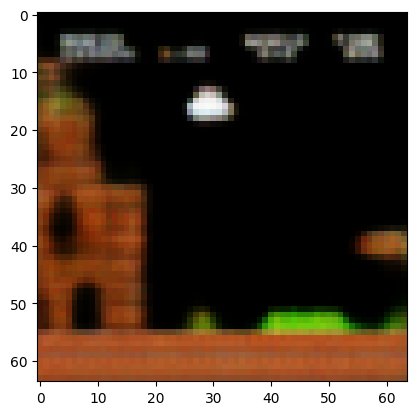

Epoch 2 start


100%|█████████▉| 6050/6063 [27:01<00:03,  3.73it/s]


Avg loss: 0.375608 



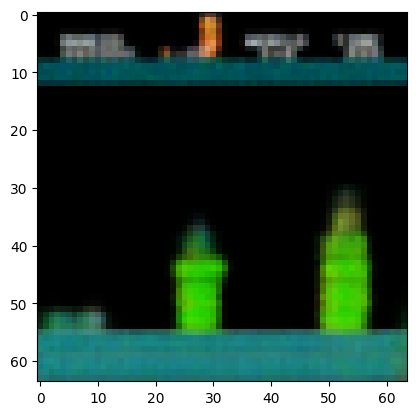

Epoch 3 start


100%|█████████▉| 6050/6063 [26:55<00:03,  3.75it/s]


Avg loss: 0.356934 



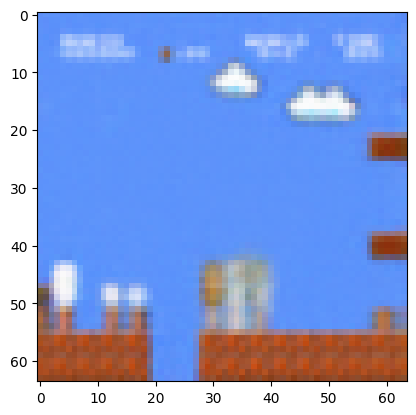

Epoch 4 start


100%|█████████▉| 6050/6063 [26:54<00:03,  3.75it/s]


Avg loss: 0.431024 



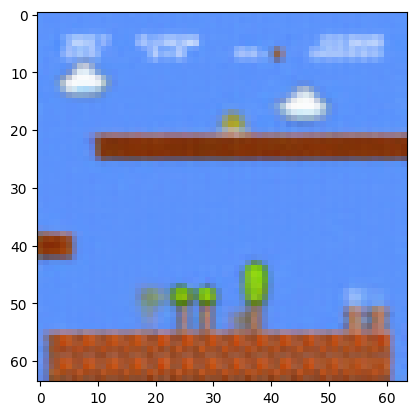

Epoch 5 start


100%|█████████▉| 6050/6063 [26:53<00:03,  3.75it/s]


Avg loss: 0.422495 



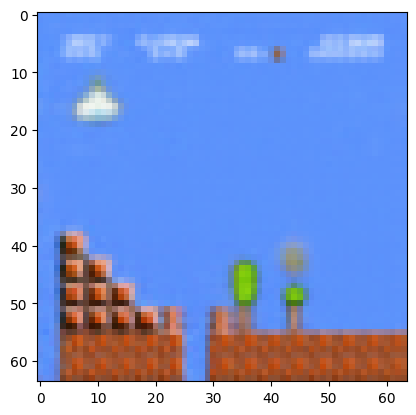

Epoch 6 start


100%|█████████▉| 6050/6063 [26:53<00:03,  3.75it/s]


Avg loss: 0.446274 



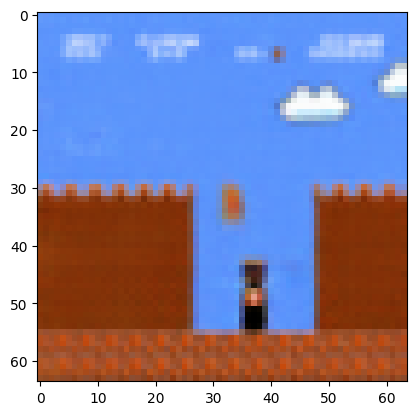

Epoch 7 start


100%|█████████▉| 6050/6063 [26:52<00:03,  3.75it/s]


Avg loss: 0.434110 



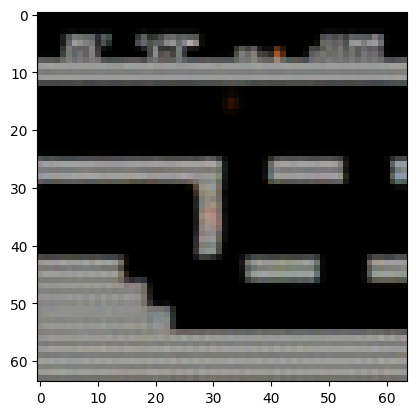

Epoch 8 start


100%|█████████▉| 6050/6063 [26:56<00:03,  3.74it/s]


Avg loss: 0.372406 



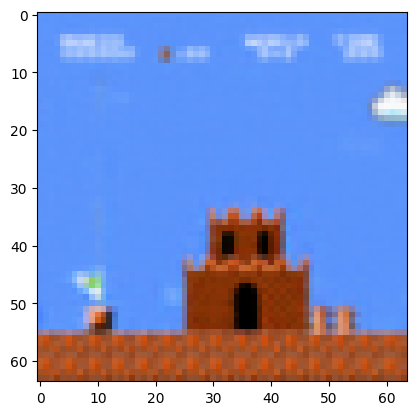

Epoch 9 start


100%|█████████▉| 6050/6063 [26:52<00:03,  3.75it/s]


Avg loss: 0.374122 



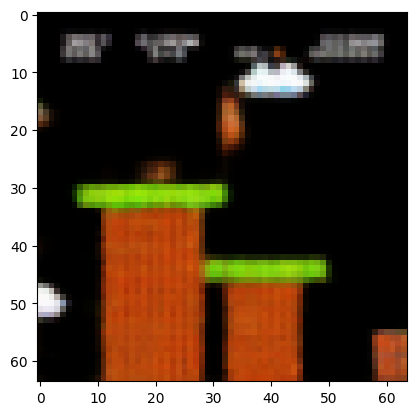

Epoch 10 start


100%|█████████▉| 6050/6063 [26:52<00:03,  3.75it/s]


Avg loss: 0.446811 



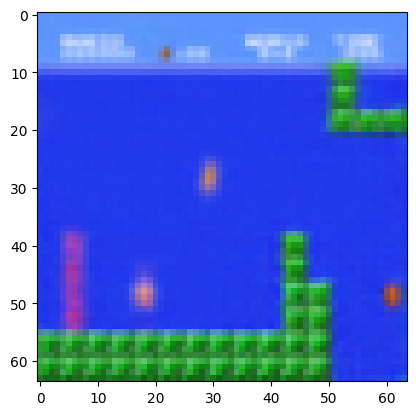

Epoch 11 start


100%|█████████▉| 6050/6063 [26:58<00:03,  3.74it/s]


Avg loss: 0.388423 



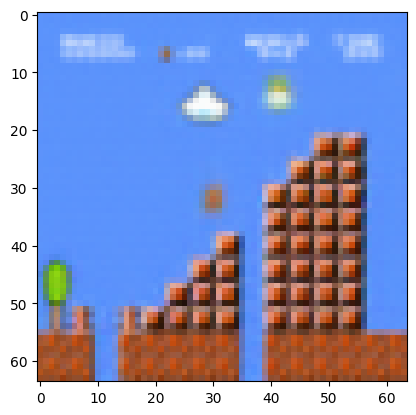

Epoch 12 start


100%|█████████▉| 6050/6063 [26:52<00:03,  3.75it/s]


Avg loss: 0.993411 



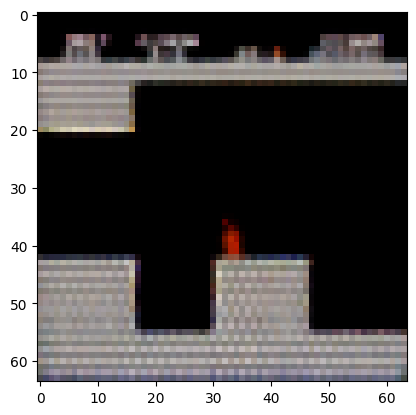

Epoch 13 start


100%|█████████▉| 6050/6063 [26:58<00:03,  3.74it/s]


Avg loss: 0.358756 



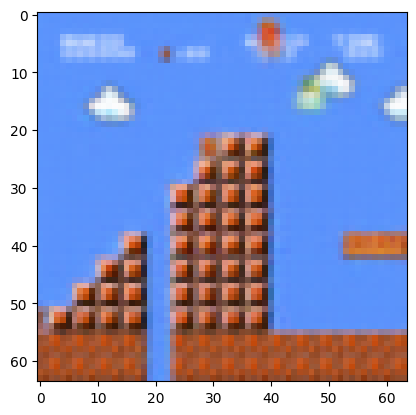

Epoch 14 start


100%|█████████▉| 6050/6063 [26:58<00:03,  3.74it/s]


Avg loss: 0.423928 



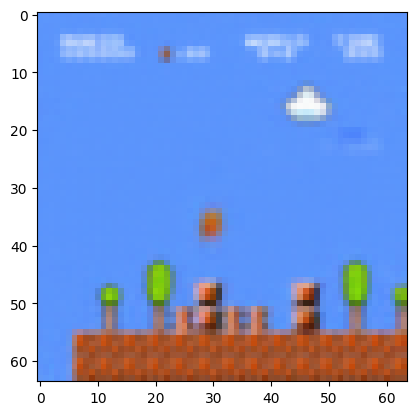

Epoch 15 start


100%|█████████▉| 6050/6063 [26:57<00:03,  3.74it/s]


Avg loss: 1.062043 



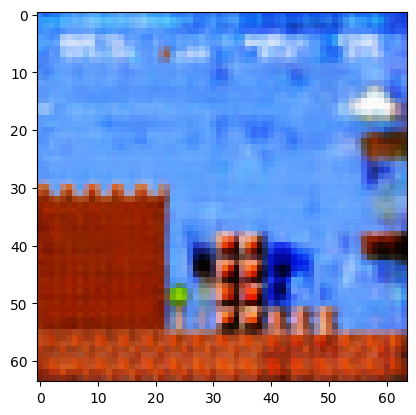

Epoch 16 start


100%|█████████▉| 6050/6063 [26:52<00:03,  3.75it/s]


Avg loss: 0.801165 



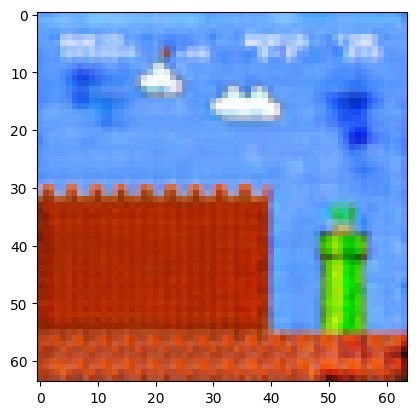

Epoch 17 start


100%|█████████▉| 6050/6063 [26:58<00:03,  3.74it/s]


Avg loss: 0.373296 



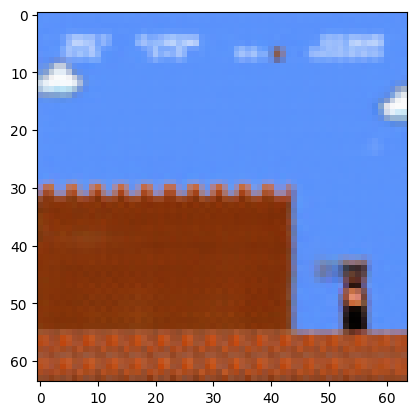

Epoch 18 start


100%|█████████▉| 6050/6063 [26:50<00:03,  3.76it/s]


Avg loss: 0.866739 



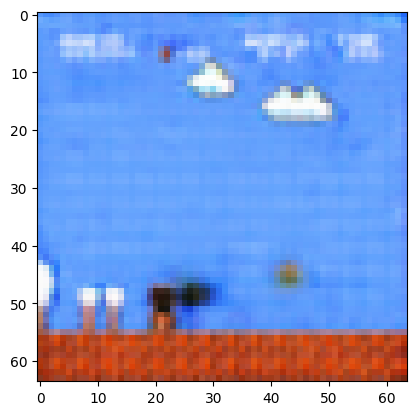

Epoch 19 start


100%|█████████▉| 6050/6063 [26:50<00:03,  3.76it/s]


Avg loss: 0.387621 



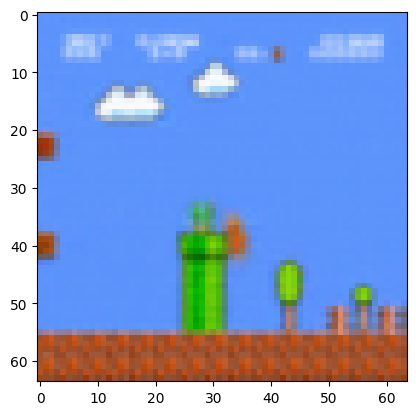

Epoch 20 start


100%|█████████▉| 6050/6063 [26:46<00:03,  3.77it/s]


Avg loss: 0.273277 



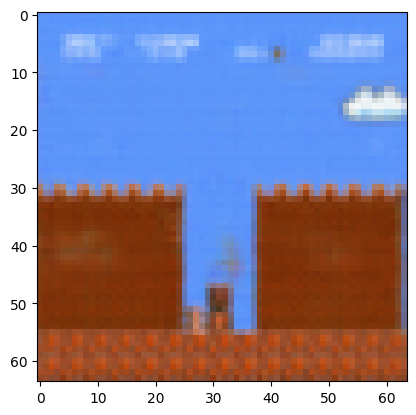

Epoch 21 start


100%|█████████▉| 6050/6063 [26:43<00:03,  3.77it/s]


Avg loss: 0.446005 



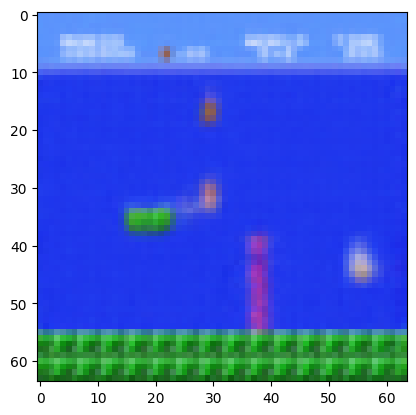

Epoch 22 start


100%|█████████▉| 6050/6063 [26:44<00:03,  3.77it/s]


Avg loss: 0.428253 



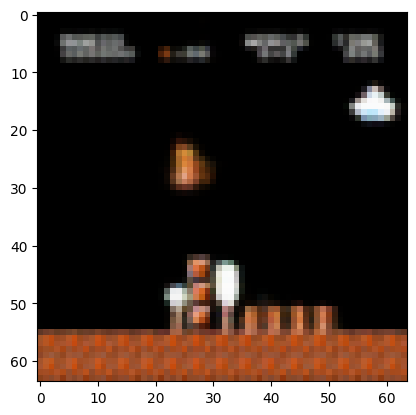

Epoch 23 start


100%|█████████▉| 6050/6063 [26:44<00:03,  3.77it/s]


Avg loss: 0.359124 



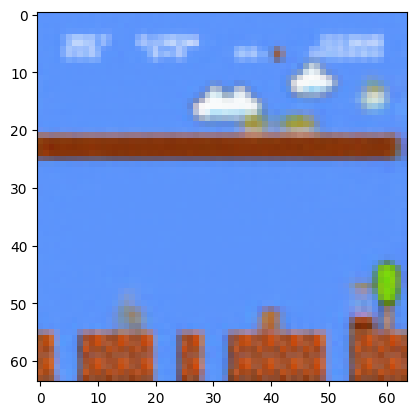

Epoch 24 start


100%|█████████▉| 6050/6063 [26:45<00:03,  3.77it/s]


Avg loss: 0.375293 



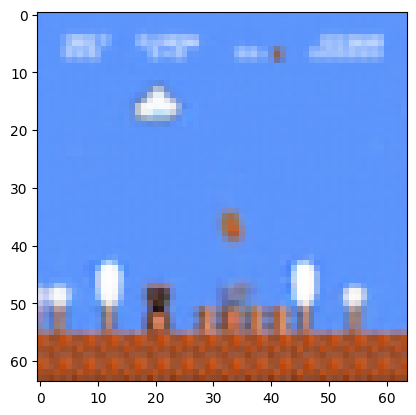

Epoch 25 start


100%|█████████▉| 6050/6063 [26:44<00:03,  3.77it/s]


Avg loss: 0.414804 



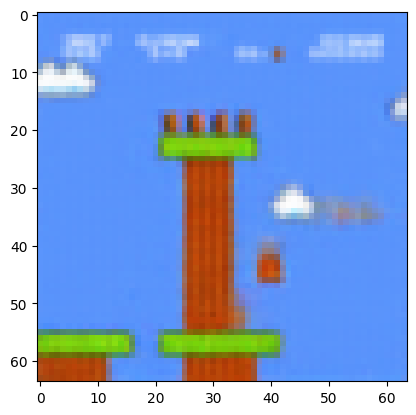

In [7]:
# Log model summary.|
with open("model_summary.txt", "w") as f:
    f.write(str(summary(model)))

for t in range(epoch, epochs+1):
    train(t)

In [8]:
x = next(iter(train_loader))

In [23]:
torch.onnx.export(model, x.to(DEVICE), "model.onnx", input_names=['image'], output_names=['image'])

## Test model

In [9]:
# checkpoint = torch.load('/home/qwest/project/PycharmProjects/Reinforsment_Learning/test_W/VAE_checkpoint_1283.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 512, kernel_size=(4, 4), 

test on exist image 

torch.Size([32, 3, 64, 64])


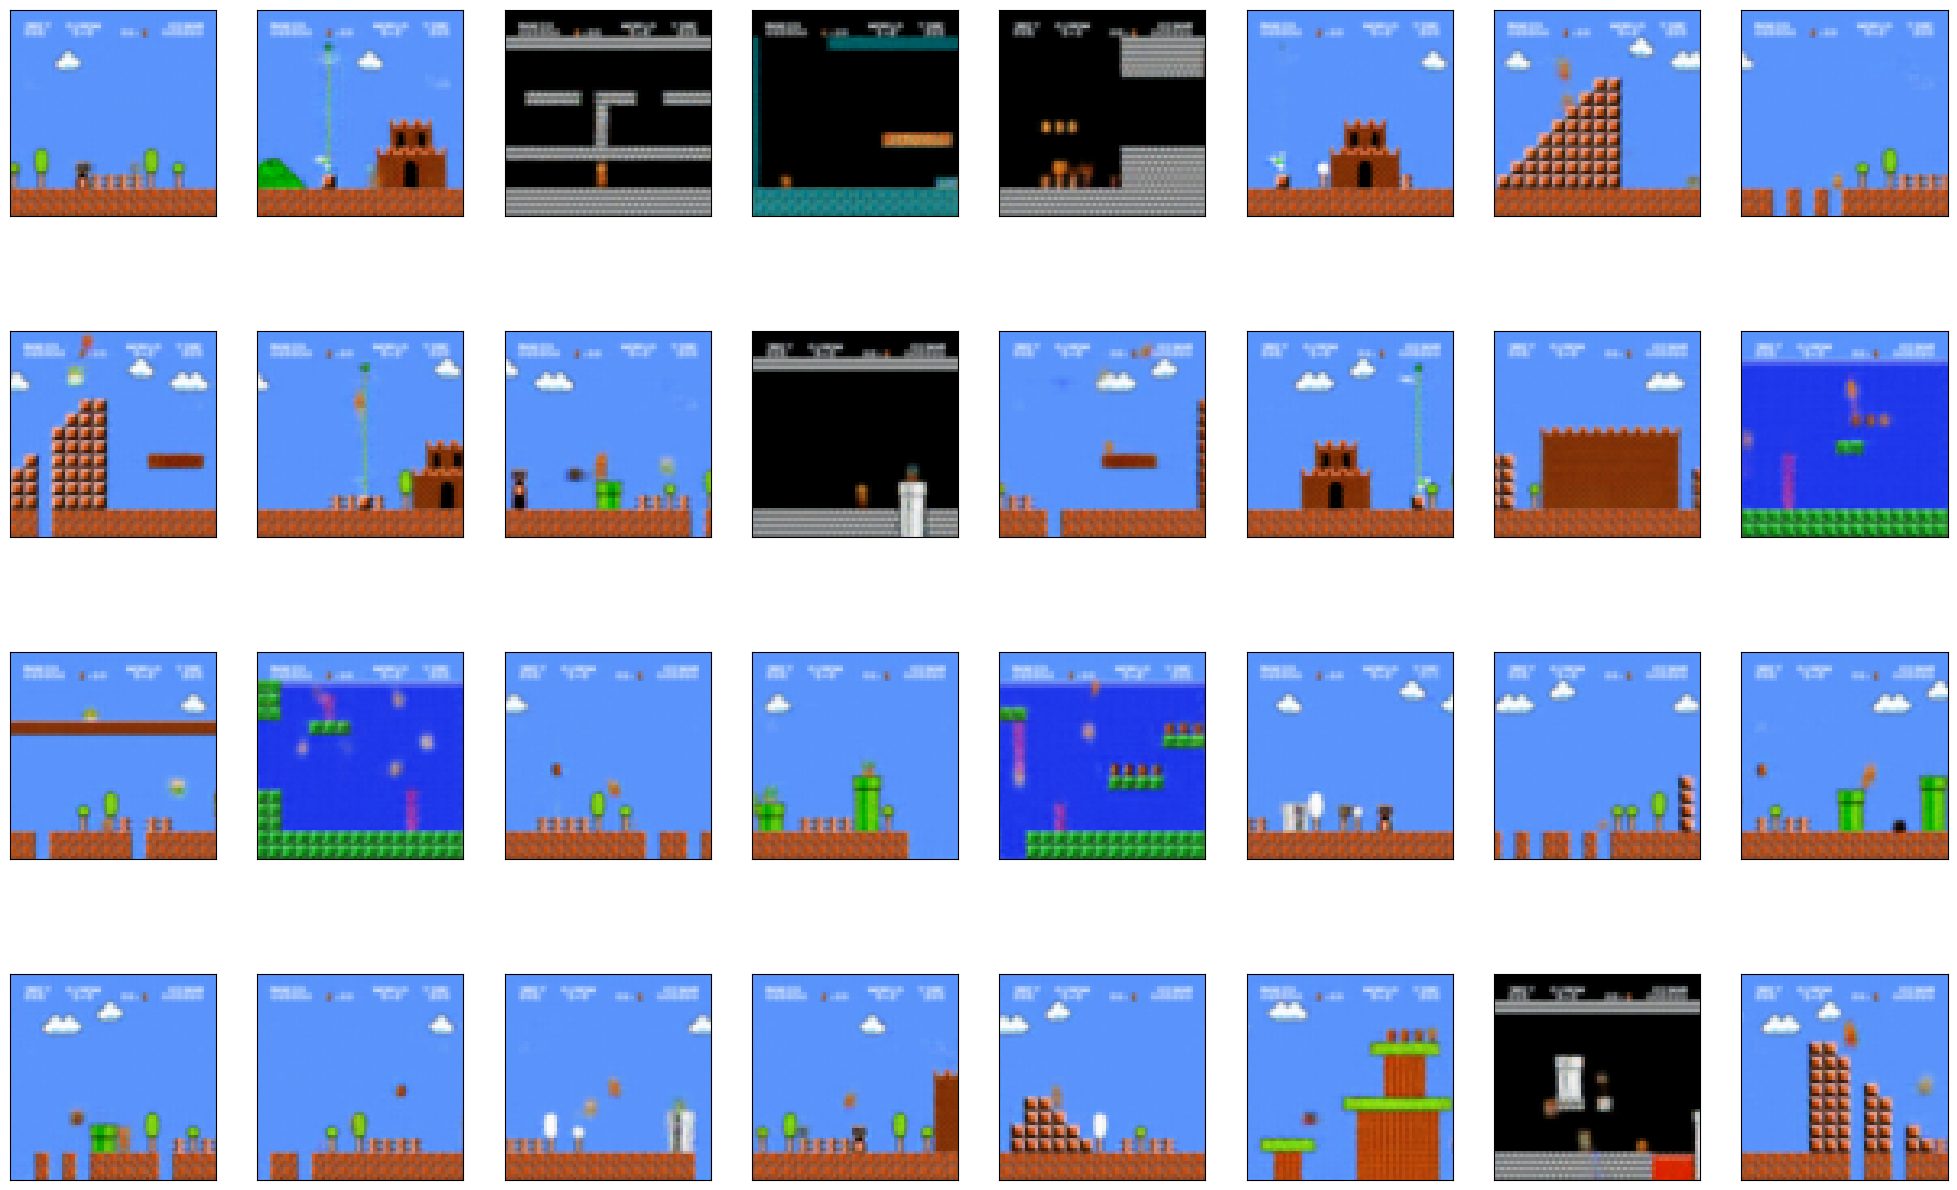

In [10]:
x = next(iter(train_loader))
print(x.size())
reconstructed, mu, _ = model(x.to(DEVICE))
reconstructed = reconstructed.view(-1, 3, 64, 64).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(reconstructed):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img))

transition of image to image

In [10]:
x = next(iter(train_loader))

In [ ]:
x[0].shape

In [15]:
Z = model.encoder(x.to(DEVICE))

In [34]:
samples = Variable(torch.randn(32, latent_dim, 4, 4)).to(DEVICE)

In [ ]:
plt.imshow(samples[3].detach().cpu().numpy())

In [ ]:
Z[0][8]

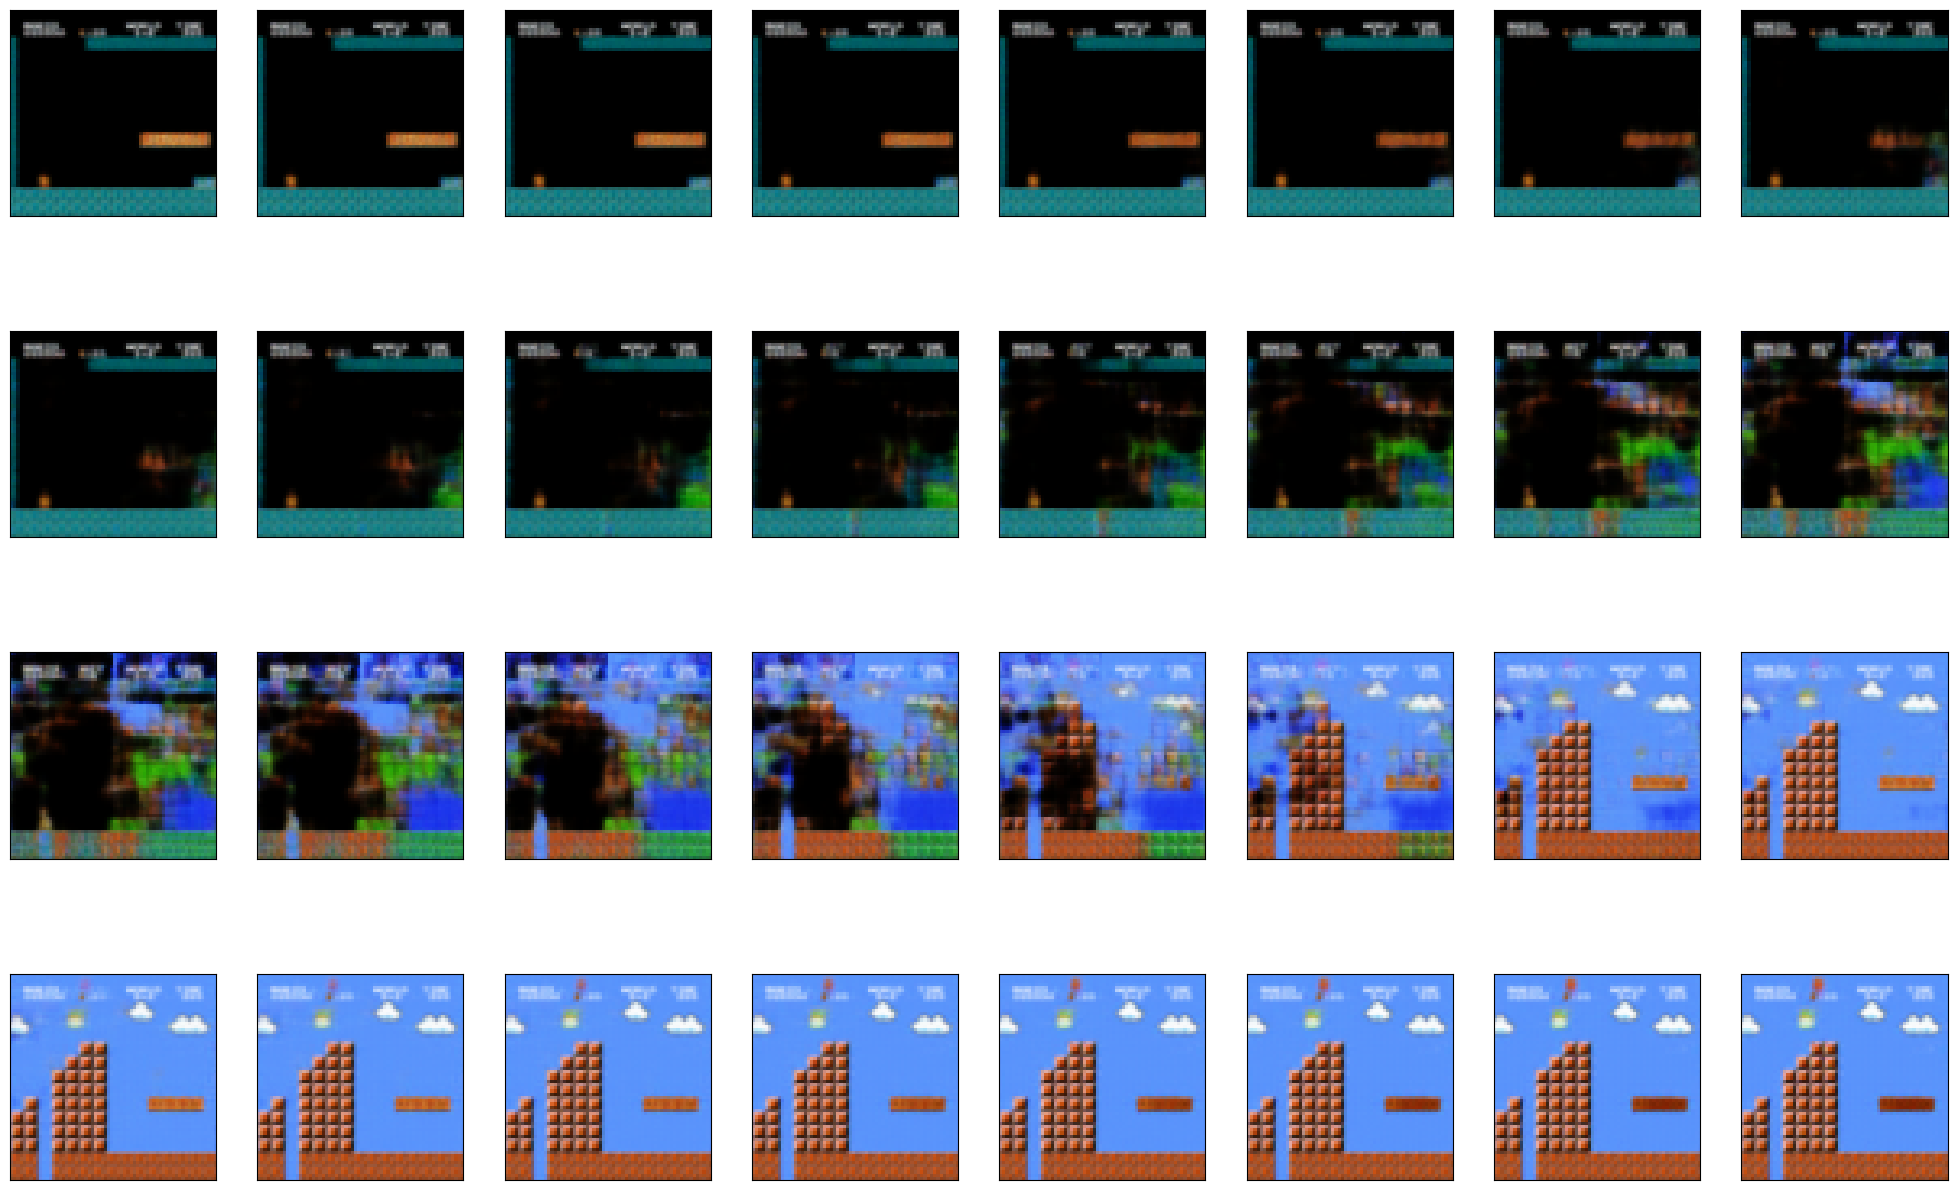

In [11]:
first_dog_idx = 3
second_dog_idx = 8

dz = (mu[second_dog_idx] - mu[first_dog_idx]) / 31
walk = Variable(torch.randn(32, latent_dim, 4, 4)).to(DEVICE)
walk[0] = mu[first_dog_idx]

for i in range(1, 32):
    walk[i] = walk[i-1] + dz
walk = model.decoder(walk).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(walk):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img))

generate image from nose

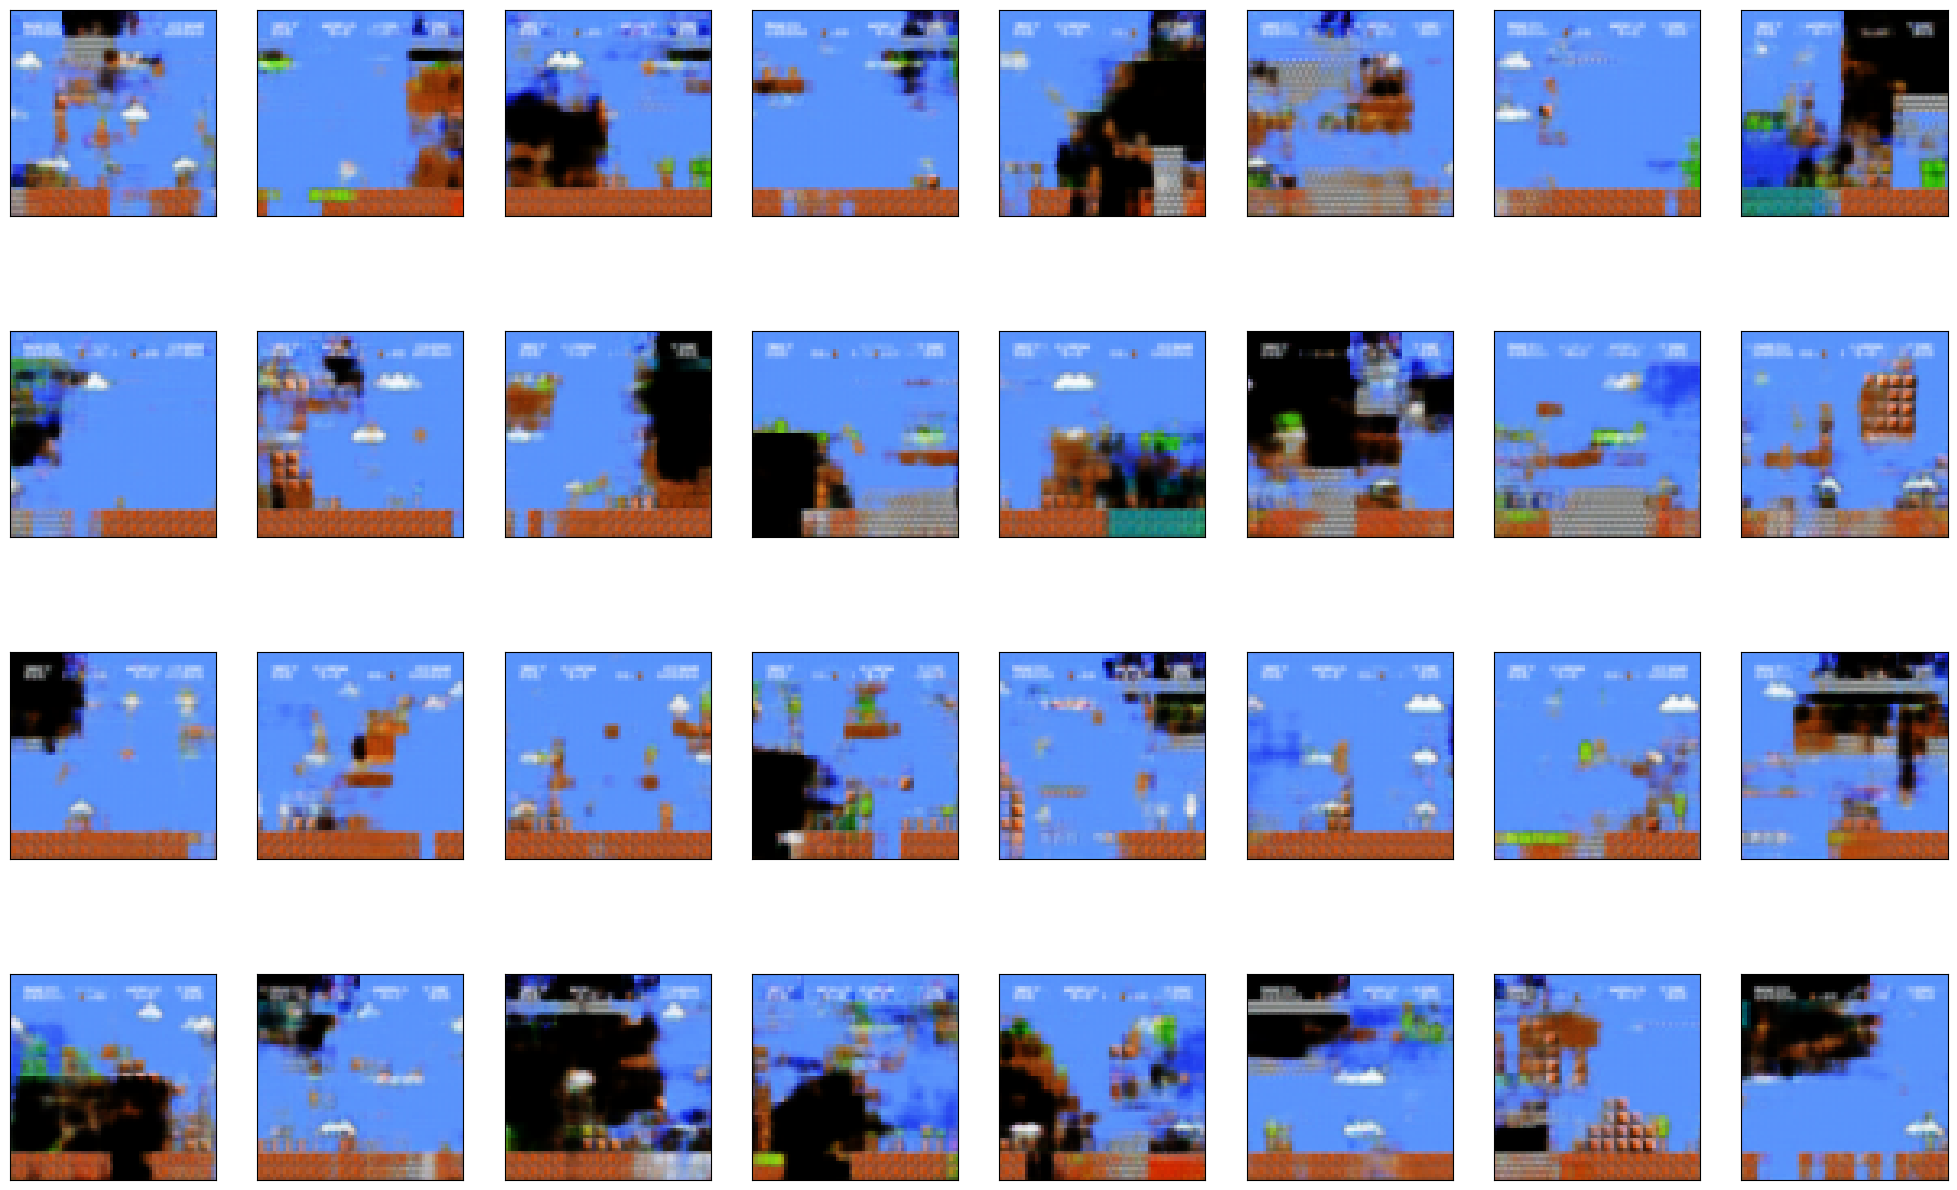

In [12]:
samples = Variable(torch.randn(32, latent_dim, 4, 4)).to(DEVICE)
samples = model.decoder(samples).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(samples):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img))

In [13]:
torch.save(model.state_dict(), "model.pt")

In [17]:
reconstructed, _, _ = model(x[0][None, :, :, :].to(DEVICE))

In [18]:
reconstructed = reconstructed.view(-1, 3, 64, 64).detach().cpu().numpy().transpose(0, 2, 3, 1)


In [ ]:
reconstructed[0].shape

In [ ]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display

# Создаем исходный массив
array = np.zeros((1, latent_dim, 4, 4))

# Функция для изменения случайных элементов
def update_array(change):
  global array # Важно указать global, чтобы функция могла изменить глобальную переменную
  indices = np.random.choice(np.arange(array.size), size=8, replace=False)
  new_values = np.random.uniform(-5.0, 5.0, size=8)
  array.reshape(-1)[indices] = new_values
  samples = model.decoder(torch.tensor(array).float().to(DEVICE)).detach().cpu().numpy().transpose(0, 2, 3, 1)
  plt.imshow(samples[0])
  #print("Modified array:\n", array)


# Создаем ползунок
slider = widgets.IntSlider(
  min=0,
  max=50, # Максимальное значение - для демонстрации, можно изменить
  step=1,
  description='Update array:',
  continuous_update=False, # Обновление только при отпускании ползунка
  orientation='horizontal',
  layout=widgets.Layout(width='500px')
)

# Связываем ползунок с функцией обновления
slider.observe(update_array, names='value')


# Выводим ползунок и начальный массив
display(slider)
#print("Initial array:\n", array)

In [ ]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import torch

# Создаем исходный массив # Замените на ваше значение latent_dim
array = np.zeros((1, 32, 4, 4))

# Инициализируем matplotlib для интерактивного режима
plt.ion()
fig, ax = plt.subplots()
img = ax.imshow(np.zeros((64,64,3))) # Инициализируем изображение нулями с тремя каналами
plt.show() # Важно показать график до начала обновления

# Функция для изменения случайных элементов
def update_array(change):
  global array, img
  indices = np.random.choice(np.arange(array.size), size=8, replace=False)
  new_values = np.random.uniform(-5.0, 5.0, size=8)
  array.reshape(-1)[indices] = new_values
  samples = model.decoder(torch.tensor(array).float().to(DEVICE)).detach().cpu().numpy().transpose(0, 2, 3, 1)
  img.set_data(samples[0]) # Обновляем данные изображения
  fig.canvas.draw()     # Перерисовываем изображение
   # Очищаем буфер событий (для гладкости)
  print(1)


# Создаем ползунок
slider = widgets.IntSlider(
  min=0,
  max=50,
  step=1,
  description='Update array:',
  continuous_update=False,
  orientation='horizontal',
  layout=widgets.Layout(width='500px')
)

# Связываем ползунок с функцией обновления
slider.observe(update_array, names='value')

# Выводим ползунок
display(slider)


In [ ]:
array

In [72]:
adf = torch.tensor(array).to(DEVICE)

In [ ]:
adf.size()

In [74]:
samples = model.decoder(torch.tensor(array).float().to(DEVICE)).detach().cpu().numpy().transpose(0, 2, 3, 1)

In [ ]:
plt.imshow(samples[0])

In [44]:
m = nn.ReLU()
input = torch.randn(100, 1000, 100, 100)
output = m(input)

In [ ]:
input

In [ ]:
output[37][23][8][5]